# Workshop Week 1: Introduction to Posthoc Interpretability

*Interpretability & Explainability in AI, MSc A.I., University of Amsterdam, June 2022*

## Lab 2: Probing Audio Models

In the previous notebook, you have trained probes on the hidden states of a fine-tuned RoBERTa model, to gain insights into how sentiment is represented in this model across layers. In this notebook, you will perform a similar analysis on an **audio-based language model: Wav2Vec2**. This self-supervised model learns powerful speech representations from raw audio data and can be applied to many downstream tasks, including **Automatic Speech Recognition (ASR)**.

Before the rise of deep learning, ASR was performed using a pipeline of different components, each performing a subpart of the task. The ASR pipeline includes the following steps:

1.   **Feature extraction**: extracting relevant time-frequency information from the raw audio signal.
2.   **Acoustic modelling**: mapping the extracted audio features to a sequence of [phonemes](https://prowritingaid.com/phoneme), the smallest meaningful units in speech. Phonemes only refer to sounds and do not necessarily match with written letters. For example, consider the words *fit*, *phone*, and *laugh*. These words all contain the same phoneme: /f/. Since the same phoneme can be written in several different ways (*f*, *ph*, *gh*), it is useful for an ASR model to have an intermediate phoneme representation.
3.   **Language modelling**: mapping the sequence of phonemes to a sequence of written words.

Self-supervised speech models such as Wav2Vec2 are able to perform all of the above steps in an **end-to-end** fashion. In this assignment, we will try to find evidence for the implicit execution of the second subcomponent: acoustic modelling. We will therefore be probing the layers of the model for **phoneme information**.







## Configuration

Don't forget to enable the GPU runtime at the top! (Runtime -> Change runtime type)

Install necessary packages:

In [ ]:
!pip install datasets==1.18.3 # we need this specific version of datasets in order to load the TIMIT data
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 34.5 MB/s eta 0:00

Connect to the GPU:

In [ ]:
from tqdm import *
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Set a random seed for reproducibility of the experiments:

In [ ]:
import numpy as np
import random

def set_seed(seed):
    """Set random seed."""
    if seed == -1:
        seed = random.randint(0, 1000)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

# The TIMIT dataset

We will use the [TIMIT Acoustic-Phonetic Continuous Speech Corpus](https://catalog.ldc.upenn.edu/LDC93S1), which contains sentence recordings of 630 speakers of eight major American-English dialects. Each speaker read aloud the same ten sentences, which were designed to elicit a wide variety of speech sounds. The corpus includes time-aligned transcriptions, as well as the raw waveform for each spoken sentence, sampled at a rate of 16 kHz.

<font color='green'>**ToDo1**</font>

Load the TIMIT corpus by running the cell below.

In [ ]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr", "clean").shuffle(seed=42)

# Print number of train and test samples
print(len(timit['train']), len(timit['test']))

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

4620 1680


<font color='green'>**ToThink1**</font>

Look at some examples of the data and try to understand the annotations.

What information is annotated in ```phonetic_detail?``` Tip: an explanation of the labels can be found [here](https://catalog.ldc.upenn.edu/docs/LDC93S1/PHONCODE.TXT).



In [ ]:
# 'file': This feature represents the file name or identifier of the audio recording. It is often used to access and retrieve the corresponding audio file from the dataset.
# 'audio': The 'audio' feature contains the actual audio waveform data for the speech utterance. It typically includes the digital representation of the speech signal, allowing researchers to analyze acoustic properties or apply signal processing techniques.
# 'text': The 'text' feature refers to the transcription of the speech utterance into written text. It provides the written representation of the spoken words or sentences.
# 'phonetic_detail': This feature contains phonetic annotations or details for the speech utterance. It includes information about the start and stop times of individual phonetic segments, allowing researchers to analyze the phonetic content and structure of the speech.
# 'word_detail': The 'word_detail' feature provides additional information about the words in the speech utterance. It may include details like the start and stop times of individual words, word transcriptions, or other linguistic information associated with each word.
# 'dialect_region': The 'dialect_region' feature represents the dialect region or accent of the speaker. It indicates the regional variation in pronunciation or speech characteristics.
# 'sentence_type': This feature indicates the type of sentence or speech context in which the utterance occurs. It may include labels like "declarative," "interrogative," or "imperative" to classify the sentence type.
# 'speaker_id': The 'speaker_id' feature identifies the specific speaker who produced the utterance. It allows for tracking and distinguishing the speech data from different individuals in the dataset.
# 'id': The 'id' feature serves as a unique identifier for the speech utterance or data instance. It is typically used for indexing or referencing purposes within the dataset.

In [ ]:
# Start: The "start" refers to the beginning or onset time of a particular phonetic segment within an utterance. Each phonetic segment represents a distinct speech sound or a combination of speech sounds. The start time indicates when a specific phonetic segment starts within the utterance.
# Stop: The "stop" refers to the end or offset time of a phonetic segment within an utterance. It represents the point at which the specific phonetic segment ends within the utterance.
# Utterance: An "utterance" refers to a single instance of speech produced by a speaker. It can be a word, a phrase, a sentence, or a longer sequence of speech. In the TIMIT dataset, each speaker utters a set of phonetically rich sentences, and the dataset provides transcriptions and corresponding start and stop times for the phonetic segments within each utterance.

In [ ]:
# YOUR CODE HERE
print(timit['train']['text'][0])
print(timit['train']['phonetic_detail'][0])
print(timit['train']['word_detail'][0])
print(timit['train']['dialect_region'][0])
print(timit['train']['sentence_type'][0])
print(timit['train']['speaker_id'][0])
print(timit['train']['id'][0])

Those answers will be straightforward if you think through them carefully first.
{'start': [0, 2120, 2600, 5480, 6680, 9160, 9650, 10760, 11800, 12490, 13320, 13800, 14760, 15707, 15999, 16680, 18200, 18600, 19240, 20013, 21389, 21723, 22224, 24040, 26280, 28520, 29117, 29409, 30203, 31480, 33000, 33800, 35720, 36804, 37305, 39000, 39960, 40546, 41720, 42440, 43738, 44156, 45736, 46864, 48288, 49000, 50520, 51426, 53240, 55480, 58280, 61026, 61694, 62613], 'stop': [2120, 2600, 5480, 6680, 9160, 9650, 10760, 11800, 12490, 13320, 13800, 14760, 15707, 15999, 16680, 18200, 18600, 19240, 20013, 21389, 21723, 22224, 24040, 26280, 28520, 29117, 29409, 30203, 31480, 33000, 33800, 35720, 36804, 37305, 39000, 39960, 40546, 41720, 42440, 43738, 44156, 45736, 46864, 48288, 49000, 50520, 51426, 53240, 55480, 58280, 61026, 61694, 62613, 64480], 'utterance': ['h#', 'dh', 'ow', 'z', 'ae', 'n', 's', 'ix', 'z', 'epi', 'w', 'el', 'bcl', 'b', 'iy', 's', 'tcl', 't', 'r', 'ey', 'tcl', 't', 'f', 'ao', 'er', 

In [ ]:
timit['train']['audio'][0]['array']

array([-2.1362305e-04,  1.5258789e-04, -3.0517578e-05, ...,
        9.1552734e-05,  1.2207031e-04,  1.2207031e-04], dtype=float32)

# The Wav2Vec2 Model

The Wav2Vec2 model was proposed in [wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations](https://arxiv.org/abs/2006.11477) by Alexei Baevski, Henry Zhou, Abdelrahman Mohamed, Michael Auli.

The model takes raw audio waveforms as input and splits them into fixed-size frames of 25 milliseconds. During pre-training, some of these frames are masked and the model has to predict the correct speech unit for the masked position. In doing so, the model learns powerful speech representations in a self-supervised manner.

After pre-training, the model can be fine-tuned for several downstream tasks. We will investigate a model version that is fine-tuned for **Automatic Speech Recognition**, i.e. predicting written transcriptions that correspond to the spoken input. More specifically, the model was fine-tuned to predict a character for each of the 25ms-frames that we discussed above. These characters are then collapsed into well-formed transcriptions using [Connectionist Temporal Classification](https://distill.pub/2017/ctc/).





<font color='green'>**ToThink2**</font>

Read [this blogpost](https://jonathanbgn.com/2021/09/30/illustrated-wav2vec-2.html) about Wav2Vec2 and make sure you understand the different components inside the model.

<font color='green'>**ToDo2**</font>

Load the model and processor by running the cell below. Examine the architecture carefully.

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Load model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Set model to evaluation mode
model.eval()
model.to(DEVICE)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

## Prepare model input and analyze transcriptions

<font color='green'>**ToDo3**</font>

The Wav2Vec 2.0 model takes raw waveforms as input. Select one waveform from the data, plot the signal and listen to the audio.

Text: Those answers will be straightforward if you think through them carefully first.


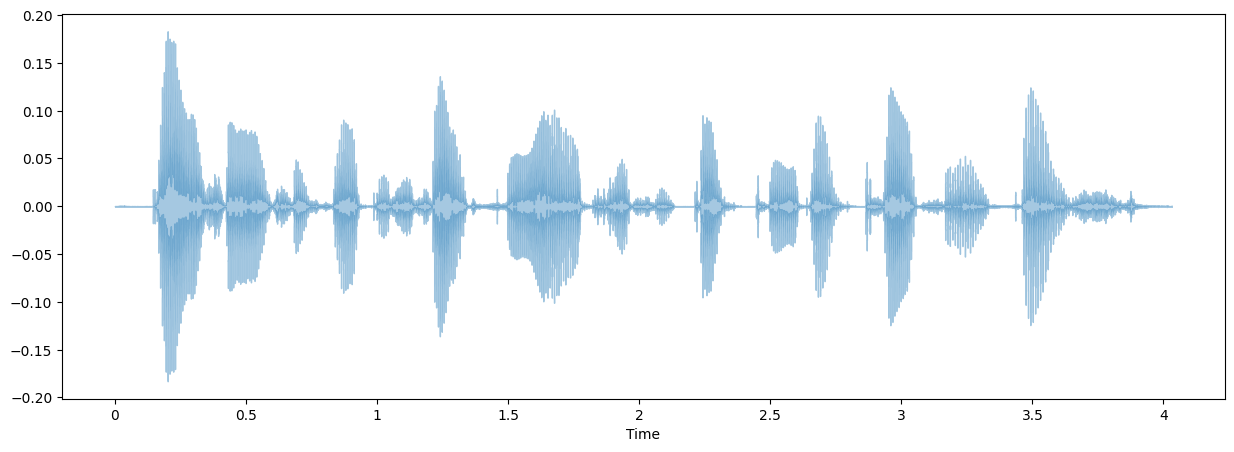

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import librosa

# Select a data item you want to examine
item_index = 0

# Retrieve the waveform from the data
raw_waveform = timit['train']['audio'][item_index]['array']

# Plot the raw waveform
plt.figure(figsize=(15,5))
librosa.display.waveshow(raw_waveform, sr=16000, alpha=0.4)

# Print corresponding text
text = timit['train']['text'][item_index]
print("Text:", text)

# Listen to the audio
ipd.Audio(data=np.asarray(raw_waveform), autoplay=False, rate=16000)

<font color='green'>**ToDo4**</font>

Let the model generate a transcription for the waveform. Are there any mistakes?

<font color='red'>**ToSubmit1**</font>

Please submit your plot of the waveform signal, together with the input text and the transcription that Wav2Vec2 generated for that particular waveform.

In [ ]:
# Tokenize
input_values = processor(raw_waveform, sampling_rate=16000, return_tensors="pt", padding="max_length", max_length=1000).input_values  # Batch size 1
print("Input shape:", input_values.shape)

# Generate transcription with the model
with torch.no_grad():
    logits = model(input_values.to(DEVICE)).logits

# Decode transcription
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)[0]
print(transcription)
#https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-dutch


Input shape: torch.Size([1, 64512])
THOSE ANSWERS WILL BE STRAIGHTFORWARD IF YOU THINK THROUGH THEM CAREFULLY FIRST


# Extract hidden states

We will now extract the hidden states from the model's Transformer layers. These hidden states will serve as the training and evaluation data for our probing classifiers.

Concretely, we will perform the following steps to achieve this:

1.  **Prepare input**: Retrieve the raw waveforms (i.e. audio arrays) from the TIMIT corpus and process them using the Wav2Vec2 processor.
2.  **Forward pass**: Pass the waveforms through the model with ```output_hidden_states``` set to True.
3. **Save hidden states**: Save the hidden states in a dictionary, which is organized by Transformer layer index and waveform index. Each waveform will have list of frame-level hidden states.
4. **Sort hidden states per phoneme class**: Sort the hidden states by phoneme class using the time-aligned transcriptions from TIMIT.



<font color='green'>**ToDo5**</font>

Finish the function below to extract the hidden states from the Transformer layers of the model. Hint: You can simply extract hidden states by calling ```.hidden_states``` on the model output.



In [ ]:
def extract_hidden_states(model, processor, inputs, num_layers):
    '''
    Extract hidden states from Wav2Vec 2.0 transformer layers.
    :param model: Wav2Vec 2.0 model
    :param processor: Wav2Vec 2.0 processor
    :param inputs: list of TIMIT instances (i.e. timit['train'] or timit['test'])
    :return: dictionary containing frame-level hidden states saved per transformer layer and per waveform
    '''

    # Get waveforms
    waveforms = [input["audio"]["array"] for input in inputs]

    # Here we will save all frame-level hidden states, sorted by layer and waveform
    frame_states = {
        layer_idx: {
            waveform_idx: []
            for waveform_idx in range(len(waveforms))
        }
        for layer_idx in range(num_layers)
    }

    for waveform_idx, waveform in enumerate(waveforms):

        print(f'Extracting hidden states from waveform {waveform_idx} out of {len(waveforms)} waveforms...')

        # Process waveform using the Wav2Vec2 processor
        processed_input = processor(waveform, sampling_rate=16000, return_tensors="pt", padding='longest').input_values

        with torch.no_grad():
            input_tensor = torch.tensor(processed_input, device=DEVICE)

            # forward pass
            model_output = model(input_tensor,output_hidden_states=True)

            # get all hidden outputs
            transformer_layers = model_output.hidden_states

        # Save frame-level hidden states, organized by layer and waveform
        for layer_idx, layer in enumerate(transformer_layers):
            for waveform in layer:
              for frame in waveform:
                  frame_states[layer_idx][waveform_idx].append(frame.cpu())

    return frame_states

Function to sort the hidden states by phoneme class using the time-aligned transcriptions from TIMIT:

In [ ]:
def sort_states_per_phoneme(data, frame_states, num_layers):

    frame_states_per_phoneme = {
        layer_idx: defaultdict(list)
        for layer_idx in range(num_layers)
    }

    for layer_idx, layer in frame_states.items():

        for waveform_idx, waveform in layer.items():

            # retrieve phoneme annotation for the current waveform
            phonemes = data[waveform_idx]["phonetic_detail"]
            phoneme_indeces = defaultdict(list)

            for start, stop, phoneme in zip(phonemes['start'], phonemes['stop'], phonemes['utterance']):

                # divide start and stop point by sample rate (16000 hz) and frame length (0.020 sec)
                start_index = math.floor((start / 16000) / 0.020)
                stop_index = math.ceil((stop / 16000) / 0.020)
                phoneme_indeces[phoneme].extend(range(start_index, stop_index))

            # find hidden states corresponding to phoneme indeces and save them per layer and per phoneme
            for phoneme, indeces in phoneme_indeces.items():
                phoneme_states = [waveform[idx] for idx in indeces if idx < len(waveform)]
                frame_states_per_phoneme[layer_idx][phoneme].extend(phoneme_states)

    return frame_states_per_phoneme

<font color='green'>**ToDo6**</font>

Extract the hidden states for training and testing our probes (this might take some time):

In [ ]:
import math
from collections import defaultdict

set_seed(42)

# We select a relatively small number of sentences since they will be split up in a large number of frames
train_size = 800
test_size = 100
num_layers = 13 # input plus 12 transformer layers

# Generate random indeces to select a subset of the train and test data
train_indeces = random.sample(range(0, len(timit['train'])), train_size)
test_indeces = random.sample(range(0, len(timit['test'])), test_size)

train_subset = timit['train'].select(train_indeces)
test_subset = timit['test'].select(test_indeces)
print(len(train_subset), len(test_subset))

# Extract frame-level hidden states for training and testing the probes (make sure you pass the data subset)
frame_states_train = extract_hidden_states(model, processor, train_subset, num_layers)
frame_states_test = extract_hidden_states(model, processor, test_subset, num_layers)

# Sort the hidden states by phoneme (make sure you pass the data subset)
phoneme_states_train = sort_states_per_phoneme(train_subset, frame_states_train, num_layers)
phoneme_states_test = sort_states_per_phoneme(test_subset, frame_states_test, num_layers)

800 100
Extracting hidden states from waveform 0 out of 800 waveforms...
Extracting hidden states from waveform 1 out of 800 waveforms...
Extracting hidden states from waveform 2 out of 800 waveforms...


<ipython-input-13-0220203f13bf>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(processed_input, device=DEVICE)


Extracting hidden states from waveform 3 out of 800 waveforms...
Extracting hidden states from waveform 4 out of 800 waveforms...
Extracting hidden states from waveform 5 out of 800 waveforms...
Extracting hidden states from waveform 6 out of 800 waveforms...
Extracting hidden states from waveform 7 out of 800 waveforms...
Extracting hidden states from waveform 8 out of 800 waveforms...
Extracting hidden states from waveform 9 out of 800 waveforms...
Extracting hidden states from waveform 10 out of 800 waveforms...
Extracting hidden states from waveform 11 out of 800 waveforms...
Extracting hidden states from waveform 12 out of 800 waveforms...
Extracting hidden states from waveform 13 out of 800 waveforms...
Extracting hidden states from waveform 14 out of 800 waveforms...
Extracting hidden states from waveform 15 out of 800 waveforms...
Extracting hidden states from waveform 16 out of 800 waveforms...
Extracting hidden states from waveform 17 out of 800 waveforms...
Extracting hidden

# Map fine-grained phoneme labels to broader categories

Phonemes can have different realizations depending on the context in which they occur, or depending on the dialect of the speaker. TIMIT contains annotations for many of these realizations (61 in total). We will merge phonemes that sound very similar into a single category, such that we end up with 39 broader categories in total.

In [ ]:
# The original labels
print(phoneme_states_train[0].keys())

dict_keys(['h#', 'q', 'aa', 'r', 'hv', 'l', 'ax', 'dx', 'ey', 'pcl', 'p', 'ix', 'n', 'z', 'v', 'eh', 'bcl', 'b', 'el', 'tcl', 't', 'uw', 'ah', 's', 'sh', 'iy', 'ae', 'dcl', 'd', 'y', 'axr', 'kcl', 'ux', 'pau', 'ih', 'gcl', 'g', 'w', 'ao', 'dh', 'th', 'ng', 'k', 'er', 'ax-h', 'f', 'm', 'ch', 'hh', 'ow', 'ay', 'epi', 'jh', 'uh', 'zh', 'en', 'aw', 'oy', 'nx', 'em', 'eng'])


In [ ]:
phoneme_mapping = {
    'p': 'p',
    'b': 'b',
    't': 't',
    'd': 'd',
    'k': 'k',
    'g': 'g',
    'dx': 'dx',
    'f': 'f',
    'v': 'v',
    'dh': 'dh',
    'th': 'th',
    's': 's',
    'z': 'z',
    'r': 'r',
    'w': 'w',
    'y': 'y',
    'jh': 'jh',
    'ch': 'ch',
    'iy': 'iy',
    'eh': 'eh',
    'ey': 'ey',
    'ae': 'ae',
    'aw': 'aw',
    'ay': 'ay',
    'oy': 'oy',
    'ow': 'ow',
    'uh': 'uh',
    'ah': 'ah',
    'ax': 'ah',
    'ax-h': 'ah',
    'aa': 'aa',
    'ao': 'aa',
    'er': 'er',
    'axr': 'er',
    'hh': 'hh',
    'hv': 'hh',
    'ih': 'ih',
    'ix': 'ih',
    'l': 'l',
    'el': 'l',
    'm': 'm',
    'em': 'm',
    'n': 'n',
    'en': 'n',
    'nx': 'n',
    'ng': 'ng',
    'eng': 'ng',
    'sh': 'sh',
    'zh': 'sh',
    'uw': 'uw',
    'ux': 'uw',
    'pcl': 'sil',
    'bcl': 'sil',
    'tcl': 'sil',
    'dcl': 'sil',
    'kcl': 'sil',
    'gcl': 'sil',
    'h#': 'sil',
    'pau': 'sil',
    'epi': 'sil'
}

# Train and evaluate probing classifiers

It is now time to train and evaluate our probes. We will define a probing classifier for each layer of the Wav2Vec2 model to see how phoneme information is represented across layers. We will be using Logistic Regression as our classification models (but feel free to experiment with other classifiers such as SVM).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings

warnings.filterwarnings("ignore")

# Define layer-wise probes, to be trained and tested on frame-level Wav2Vec2 embeddings
layer_probes = {
    layer_idx: LogisticRegression(solver="liblinear", penalty="l2", max_iter=10)
    for layer_idx in range(num_layers)
}

Helper functions for putting the data in the right format for Logistic Regression models, and for balancing the data:

In [ ]:
def data_loader(hidden_state_dict, layer_idx, target_phonemes=None):
    X = []
    y = []

    for phoneme, hidden_state_list in hidden_state_dict[layer_idx].items():
        for i in hidden_state_list:
            if i != None and phoneme != 'q':
                if target_phonemes == None:
                    X.append(np.array(i))
                    y.append(phoneme_mapping[phoneme])
                else:
                    if phoneme in target_phonemes:
                        X.append(np.array(i))
                        y.append(phoneme_mapping[phoneme])

    return X, y

def balance_classes(X_instances, y_labels):

    balanced_data_X = []
    balanced_data_y = []

    class_distribution = Counter(y_labels)
    num_instances_per_class = min(class_distribution.values())

    for label in class_distribution.keys():

        i = 1
        instances = []
        labels = []

        for x, y in zip(X_instances, y_labels):
            if y == label:
                instances.append(x)
                labels.append(y)
                if i == num_instances_per_class:
                    balanced_data_X.extend(instances)
                    balanced_data_y.extend(labels)
                    break
                i += 1

    return balanced_data_X, balanced_data_y

<font color='green'>**ToDo7**</font>

Train and evaluate the probing classifier for each layer (this will take some time). Examine the difference in probing accuracy when predicting different categories of phonemes (i.e. stops, fricatives, nasals, glides, vowels). The different categories are explained [here](http://www.ello.uos.de/field.php/PhoneticsandPhonology/MannerOfArticulation).

In [ ]:
from collections import Counter

phoneme_dict = {
    'stops': ['p', 't', 'k', 'b', 'd', 'g'],
    'fricatives': ['f', 'v', 'th', 'dh', 's', 'z', 'sh'],
    'nasals': ['m', 'n', 'ng'],
    'approximants': ['l', 'w', 'y', 'hh'],
    'vowels': ['aa', 'ow', 'iy', 'eh', 'uh']
}

# Save layer-wise accuracies for each phoneme category
accs_per_category = []

for phoneme_category, target_phonemes in phoneme_dict.items():

  print(f"Training layer-wise probes to predict {phoneme_category}...")
  accs = []

  # Train and test an individual probe for each layer
  for layer_idx in range(num_layers):

    # Put train data in the right format for our probing classifier + balance classes
    train_X, train_y = data_loader(phoneme_states_train, layer_idx, target_phonemes=target_phonemes)
    train_X, train_y = balance_classes(train_X, train_y)

    if layer_idx == 0:
      print("Balanced class distribution TRAIN:", Counter(train_y))

    # Train model
    layer_probes[layer_idx].fit(train_X, train_y)

    # Put test data in the right format for our probing classifier + balance classes
    test_X, test_y = data_loader(phoneme_states_test, layer_idx, target_phonemes=target_phonemes)
    test_X, test_y = balance_classes(test_X, test_y)

    if layer_idx == 0:
      print("Balanced class distribution TEST:", Counter(test_y))

    # Predict
    test_pred = layer_probes[layer_idx].predict(test_X)

    # Calculate accuracy
    test_acc = accuracy_score(test_y, test_pred)
    print(f'Accuracy for layer {layer_idx}:', test_acc)
    accs.append(test_acc)

  accs_per_category.append(accs)

Training layer-wise probes to predict stops...
Balanced class distribution TRAIN: Counter({'p': 775, 'b': 775, 't': 775, 'd': 775, 'g': 775, 'k': 775})
Balanced class distribution TEST: Counter({'b': 102, 'p': 102, 'd': 102, 'k': 102, 't': 102, 'g': 102})
Accuracy for layer 0: 0.8088235294117647
Accuracy for layer 1: 0.8235294117647058
Accuracy for layer 2: 0.8758169934640523
Accuracy for layer 3: 0.9133986928104575
Accuracy for layer 4: 0.9558823529411765
Accuracy for layer 5: 0.9624183006535948
Accuracy for layer 6: 0.9722222222222222
Accuracy for layer 7: 0.9738562091503268
Accuracy for layer 8: 0.9836601307189542
Accuracy for layer 9: 0.9803921568627451
Accuracy for layer 10: 0.9787581699346405
Accuracy for layer 11: 0.9754901960784313
Accuracy for layer 12: 0.9444444444444444
Training layer-wise probes to predict fricatives...
Balanced class distribution TRAIN: Counter({'z': 777, 'v': 777, 's': 777, 'sh': 777, 'dh': 777, 'th': 777, 'f': 777})
Balanced class distribution TEST: Coun

<font color='green'>**ToDo8**</font>

Plot the layer-wise accuracies per phoneme category.

<font color='green'>**ToThink3**</font>

Does the layer-wise evolution of phoneme information match with the subcomponents in the traditional ASR pipeline?

<font color='red'>**ToSubmit2**</font>

Please submit your plot of the probing results. Make sure to add a caption in which you briefly explain the observed pattern of the probing accuracies over layers and how this relates to the traditional ASR pipeline.

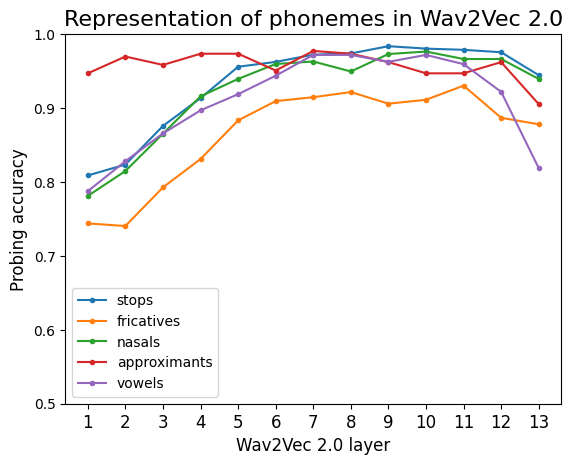

In [ ]:
for accs in accs_per_category:

  # Plot layer-wise probing accuracy per phoneme category
  plt.plot(range(num_layers), accs, marker='.')
  plt.title(f'Representation of phonemes in Wav2Vec 2.0', fontsize=16)
  plt.xlabel('Wav2Vec 2.0 layer', fontsize=12)
  plt.xticks(range(num_layers), range(1, 14), fontsize=12)
  plt.ylabel('Probing accuracy', fontsize=12)
  plt.legend(list(phoneme_dict.keys()))
  plt.ylim((0.5, 1.0))

plt.show()